# Importing Libraries and Downloading Data

In [10]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Assignment 1

In [11]:
def stochastic_oscillator(data, period=14):
    highs = data['High']
    lows = data['Low']
    closes = data['Close']
 
    highs_max = highs.rolling(window=period).max()
    lows_min = lows.rolling(window=period).min()
 
    data['fast_k'] = 100 * ((closes - lows_min) / (highs_max - lows_min))
 
    data['slow_k'] = data['fast_k'].rolling(window=3).mean()

In [12]:
def aroon(data, period=25):
    
    data['aroon_up'] = 100 * data.High.rolling(period).apply(lambda x: x.argmax()) / (period)
    data['aroon_down'] = 100 * data.Low.rolling(period).apply(lambda x: x.argmin()) / (period)
    
    plt.figure(figsize=(10, 6))
    data['aroon_up'].plot(label='Aroon Up')
    data['aroon_down'].plot(label='Aroon Down')
    plt.ylabel('Aroon')
    plt.legend()
    plt.show()

In [13]:
def MACD(data, column_name, win_small=12, win_big=26, win_sig=9):
    data['EMA_'+column_name+str(win_small)] = data[column_name].ewm(span=win_small, adjust=False).mean()

    # Calculate the 26-period EMA
    data['EMA_'+column_name+str(win_big)] = data[column_name].ewm(span=win_big, adjust=False).mean()
    
    data['MACD_'+column_name] = data['EMA_'+column_name+str(win_small)] - data['EMA_'+column_name+str(win_big)]

    # Calculate the 9-period EMA of MACD (Signal Line)
    data['Signal_Line_'+column_name] = data['MACD_'+column_name].ewm(span=9, adjust=False).mean()



In [14]:
def strat_tester(df, signals):
    
    try:
        first_buy_index = list(signals).index(1)
    except ValueError:
        print("No buy signal (1) in the signals list.")
        return
    
    signals[:first_buy_index] = [0] * first_buy_index
    
    last_signal=1
    
    for i in range(first_buy_index,len(signals)-1):
        
        if signals[i]==last_signal:
            signals[i]=0
            
        elif signals[i]==1:
            last_signal=1
            
        elif signals[i]==-1:
            last_signal=-1
            
    if last_signal==1:
        signals[-1]=-1
        
    else:
        signals[-1]=0
        
    #strat_results=pd.DataFrame(signals,columns=['signals'])
    action_dates = df[signals!=0]
    
    trade_returns = []
    cum_returns = []
    total_simple_return = 0
    positive_outcome = 0
    
    for i in range(0, len(action_dates) - 1, 2):
        buy_price = action_dates.Close.iloc[i]
        sell_price = action_dates.Close.iloc[i + 1]
        
        single_trade_return = (sell_price - buy_price) / buy_price
        trade_returns.append(single_trade_return)
        total_simple_return += single_trade_return
        
        if i == 0:
            cum_returns.append(single_trade_return)
        else:
            cum_returns.append((1 + cum_returns[-1]) * (1 + single_trade_return) - 1)
        
        if single_trade_return > 0:
            positive_outcome += 1
            
    print("Simple return: ", total_simple_return)
    print("Cumulative return: ", cum_returns[-1])
    print("% positive trades: ", 2*positive_outcome/len(action_dates))
    
    mean_trade = np.mean(trade_returns)
    std_dev_trade = np.std(trade_returns, ddof=1)  
    sharpe_ratio = np.sqrt(len(trade_returns)) * (mean_trade / std_dev_trade)
    print("Sharpe Ratio: ", sharpe_ratio)
    
    cum_returns_array = np.array(cum_returns)
    cumulative_max = np.maximum.accumulate(cum_returns_array)
    drawdown = (cum_returns_array - cumulative_max) / cumulative_max
    print("Maximum drawdown: ", drawdown.min())
    
    plt.figure(figsize=(10, 6))
    plt.plot(drawdown, label='Drawdown')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.show()
    

In [15]:
def strat_apply(stock,period_):
    
    data_ticker = yf.Ticker(stock)
    data = data_ticker.history(period=period_)
    
    data = data.reset_index()
    stochastic_oscillator(data)
    aroon(data)
    column_name='fast_k'
    MACD(data, column_name,3,10,5)
    
    w0=1
    w1=5
    weights=np.array([w0,w1])
    weights= weights/weights.sum()
    
    indicator= weights[0]*(data.aroon_up-data.aroon_up)/100 - weights[1] * (data['MACD_'+column_name] - data['Signal_Line_'+column_name]) / data['MACD_'+column_name] 
    threshold_buy=0.5
    threshold_sell=-0.5
    signals= [0]*len(indicator)
    last_buy_price=0
    stoploss=0.9
    for i in range(len(indicator)):
        if indicator[i]>threshold_buy:
            signals[i]=1
            last_buy_price=data.Close[i]
        elif indicator[i]<threshold_sell or data.Close[i]<=stoploss*last_buy_price:
            signals[i]=-1
    signals=np.array(signals)
    
    strat_tester(data, signals)
    

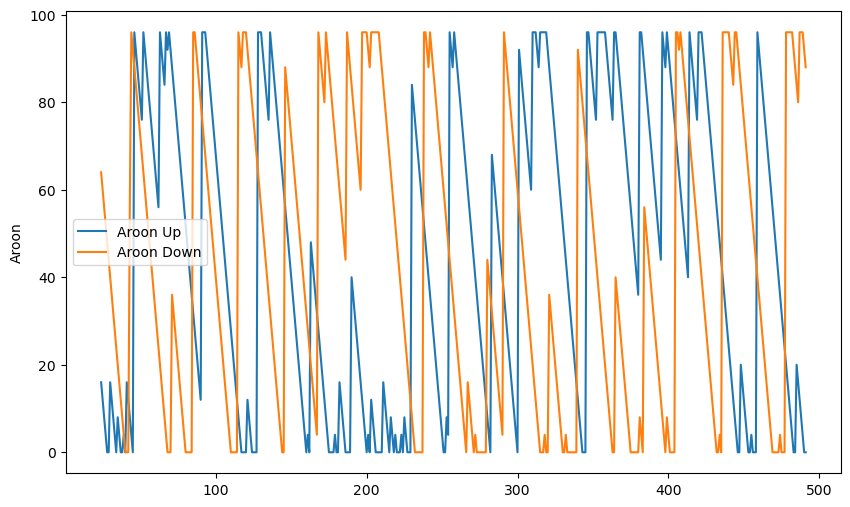

Simple return:  1.7561176290336045
Cumulative return:  2.740101891670143
% positive trades:  0.5084745762711864
Sharpe Ratio:  1.7477920341142585
Maximum drawdown:  -0.7876996291603937


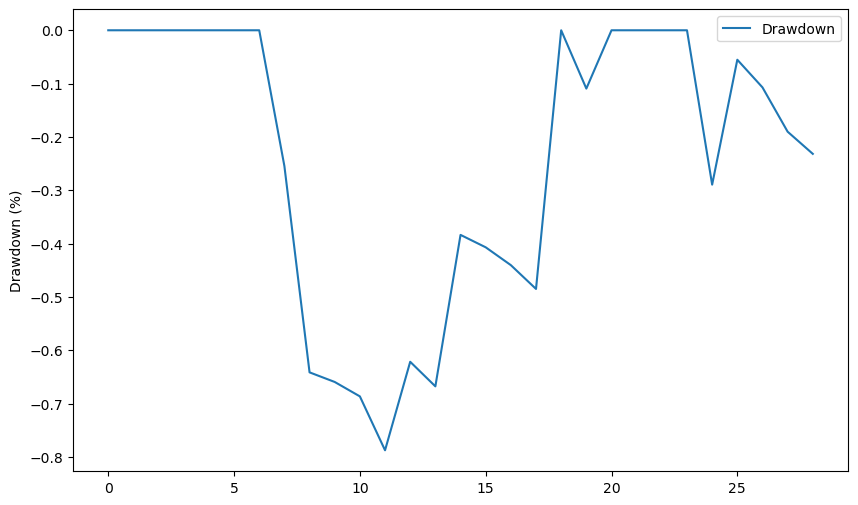

In [16]:
strat_apply('JPASSOCIAT.NS','2y')

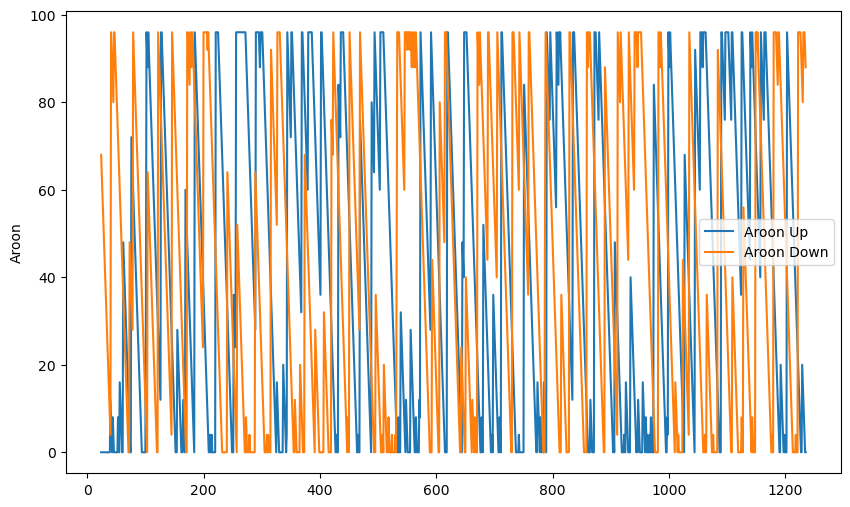

Simple return:  3.238770512247012
Cumulative return:  6.023682558079921
% positive trades:  0.4528301886792453
Sharpe Ratio:  1.8528402754175806
Maximum drawdown:  -14.233524225579611


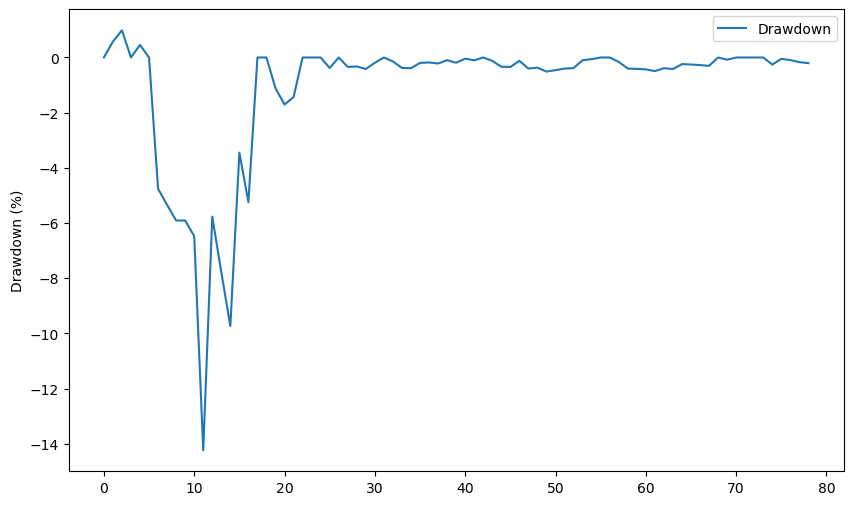

In [17]:
strat_apply('JPASSOCIAT.NS','5y')

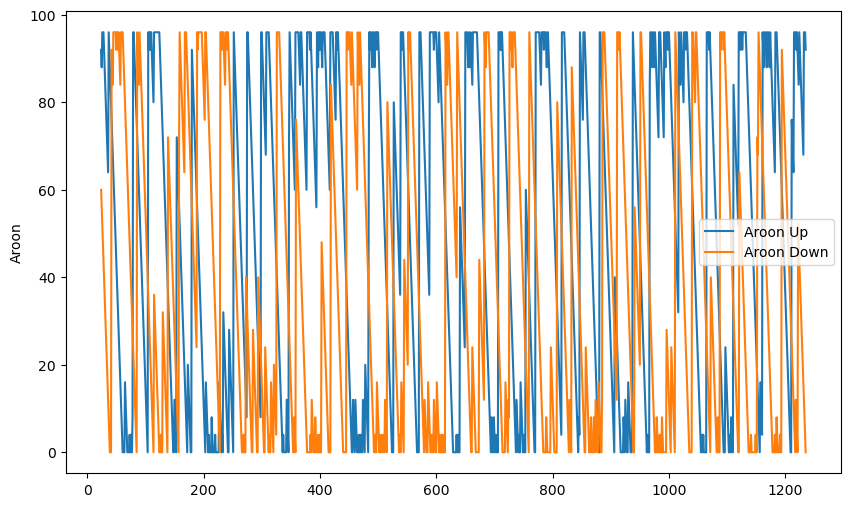

Simple return:  1.1349320160921752
Cumulative return:  1.3325001063436281
% positive trades:  0.5562130177514792
Sharpe Ratio:  1.4442066405745166
Maximum drawdown:  -0.5073344518729599


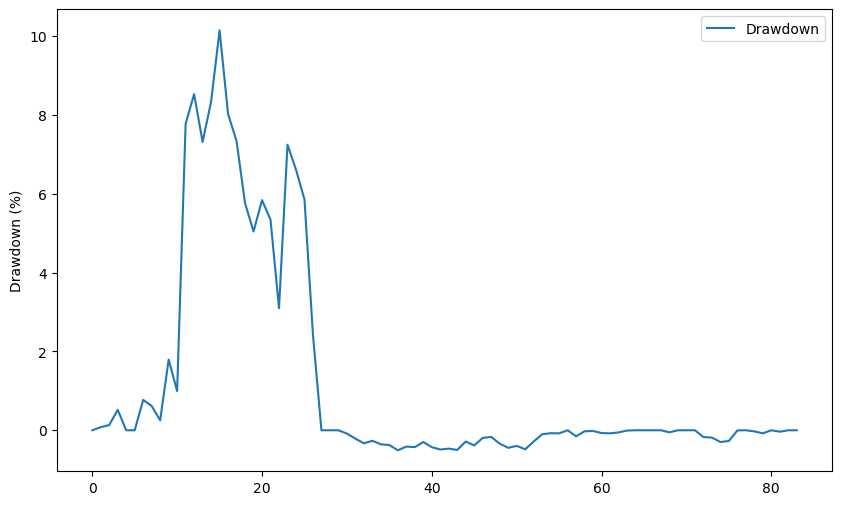

In [18]:
strat_apply('SBIN.NS','5y')

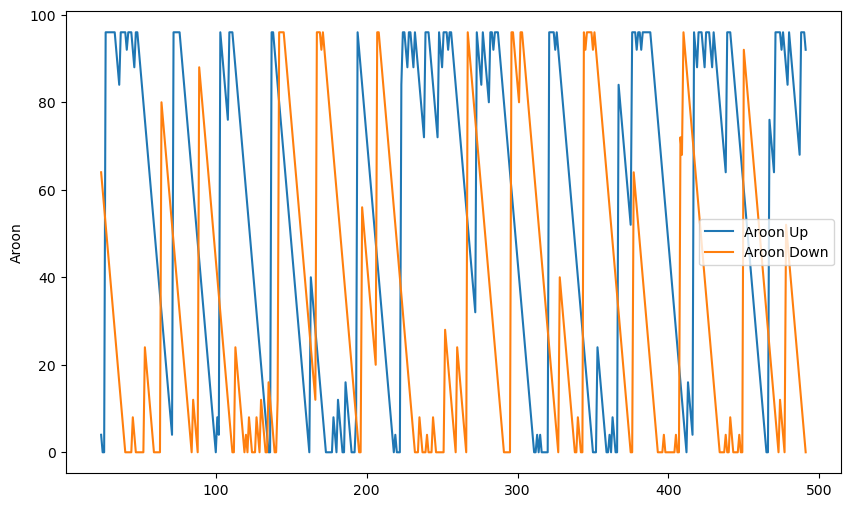

Simple return:  0.5124895782616955
Cumulative return:  0.5979398697109313
% positive trades:  0.6349206349206349
Sharpe Ratio:  1.7192790596582646
Maximum drawdown:  -0.7120829760820825


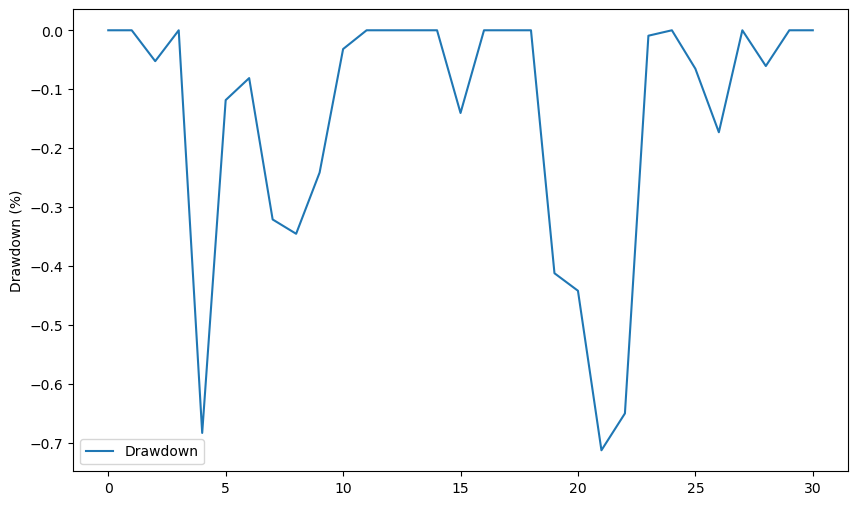

In [19]:
strat_apply('SBIN.NS','2y')

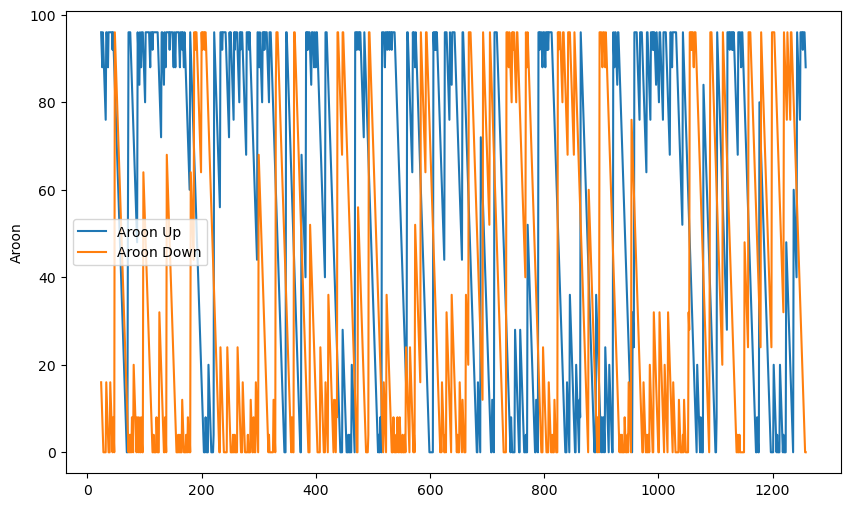

Simple return:  1.7491768304394268
Cumulative return:  3.827871733266381
% positive trades:  0.6666666666666666
Sharpe Ratio:  3.0336930817851893
Maximum drawdown:  -0.38437165484552216


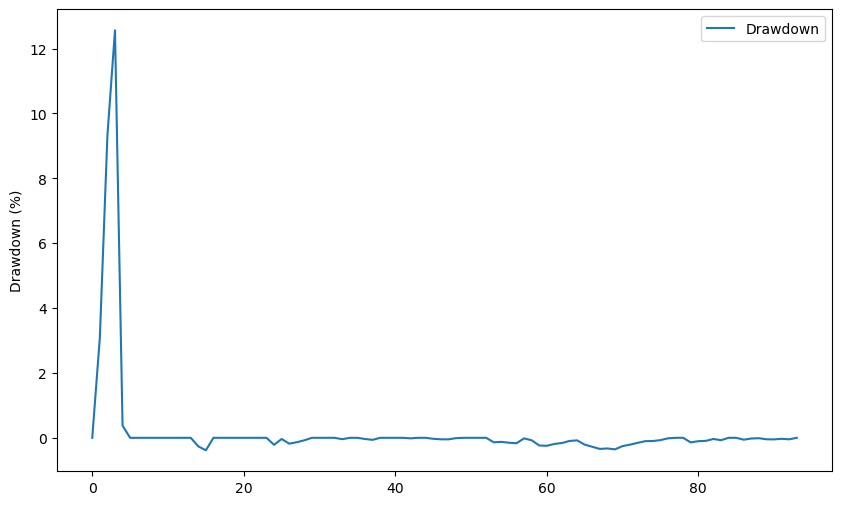

In [20]:
strat_apply('AAPL','5y')

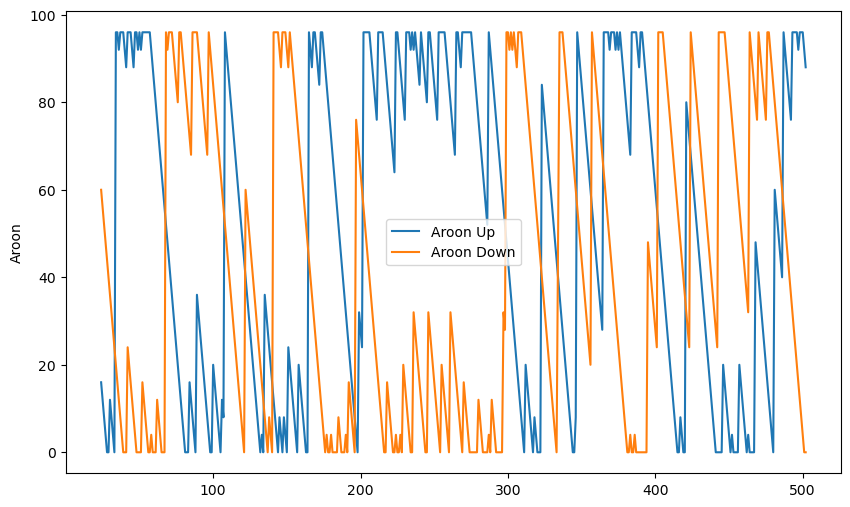

Simple return:  0.38929983834606274
Cumulative return:  0.4102791066032925
% positive trades:  0.676923076923077
Sharpe Ratio:  1.2959270010128858
Maximum drawdown:  -2.516780452333952


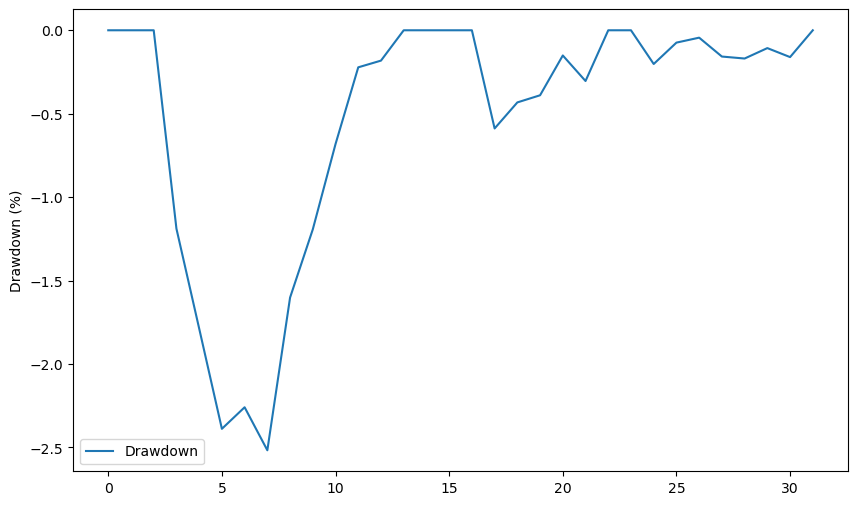

In [21]:
strat_apply('AAPL','2y')

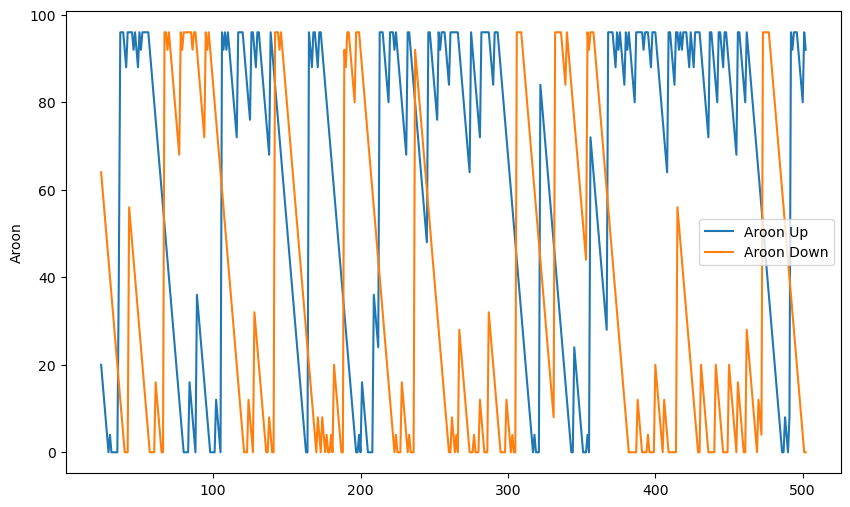

Simple return:  0.37838969412051215
Cumulative return:  0.4335131931682814
% positive trades:  0.7536231884057971
Sharpe Ratio:  2.067582894919882
Maximum drawdown:  -4.156996167161208


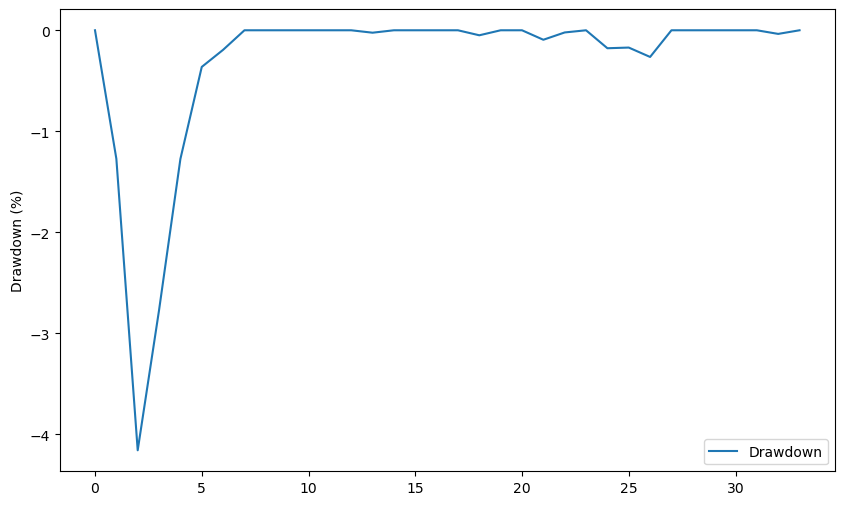

In [22]:
strat_apply('^GSPC','2y')

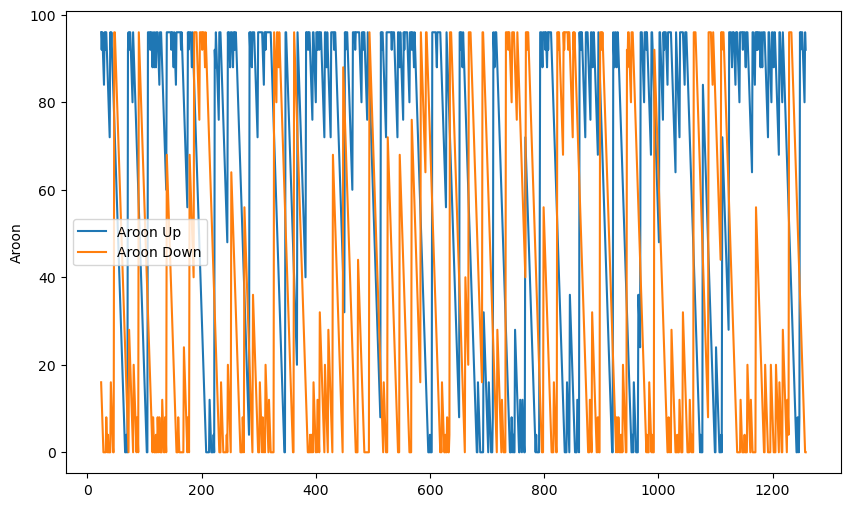

Simple return:  1.0018193576021486
Cumulative return:  1.56236441231911
% positive trades:  0.7052023121387283
Sharpe Ratio:  2.9553270611602365
Maximum drawdown:  -3.270225391774849


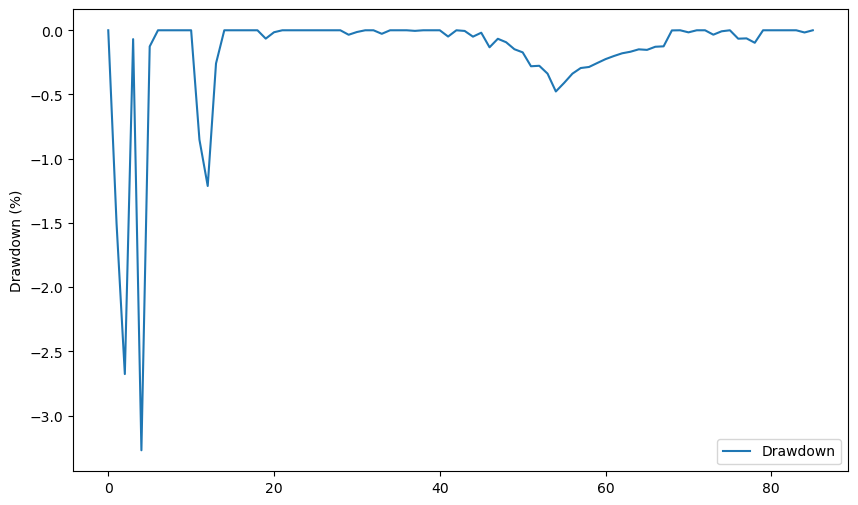

In [23]:
strat_apply('^GSPC','5y')